## Imports

In [1]:
from nb_utils import set_root

PROJECT_ROOT = set_root(4, "src")

In [2]:
from functools import partial
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, cohen_kappa_score, f1_score,
                             precision_score, recall_score)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from mlpr.ml.supervisioned.classification.utils import generate_colors
from mlpr.ml.supervisioned.surrogates.surrogates import Surrogate

## Parameters

In [3]:
random_state: int = 42
n_feats: int = 2
n_size: int = 1000
centers: list[tuple] = [
    (0, 2),
    (2, 0),
    (5, 4.5)
]
n_class: int = len(centers)
cluster_std: list[float] = [1.4, 1.4, 1.4]
cv: int = 5

np.random.seed(random_state)

params: dict[str, dict[str, any]] = {
    "n_samples": n_size,
    "n_features": n_feats,
    "centers": centers,
    "cluster_std": cluster_std,
    "random_state": random_state
}

In [4]:
params_split: dict[str, any] = {'test_size': 0.2, 'random_state': 42}
params_norm: dict[str, bool] = {'with_mean': True, 'with_std': True}
model_metrics: dict[str, Callable] = {
    'custom_accuracy': partial(accuracy_score, normalize=False),
    'accuracy': accuracy_score,
    'precision_weighted': partial(precision_score, average='macro'),
    'recall': partial(recall_score, average='macro'),
    'kappa': cohen_kappa_score,
    'f1': partial(f1_score, average='macro'),
}

In [5]:
black_box: dict[BaseEstimator, dict] = {
    RandomForestClassifier: {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [random_state]
    },
    GradientBoostingClassifier: {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01, 0.005],
        'subsample': [0.5, 0.8, 1.0],
        'random_state': [random_state]
    },
    GaussianNB: {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    SVC: {
        'C': [0.01, 0.1, 1.0, 10.0],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'probability': [True],
        'random_state': [random_state]
    }
}

white_box: dict[BaseEstimator, dict] = {
    DecisionTreeClassifier: {
        'random_state': [42],
        'max_depth': [1, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    LogisticRegression: {
        'random_state': [42],
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    }
}

## Load dataset

In [6]:
X, y = make_blobs(
    **params
)

## View the dataset

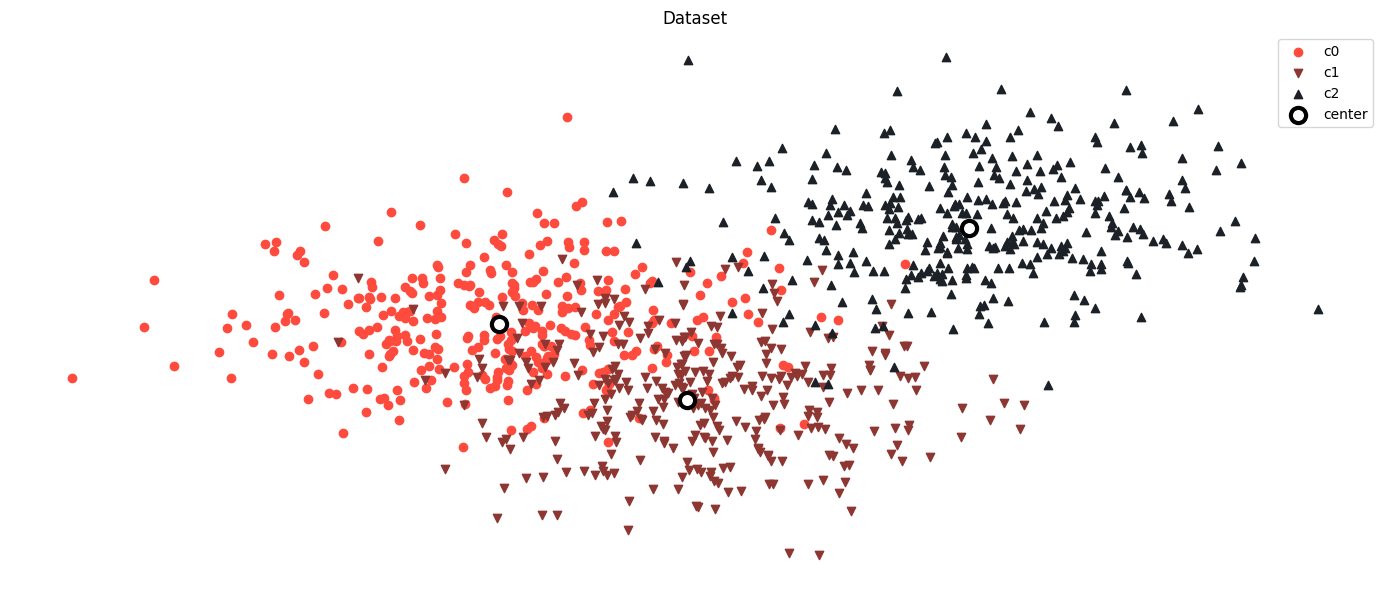

In [7]:
markers = ['o', 'v', '^']
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

colors = generate_colors("FF4B3E", "1C2127", len(np.unique(y)))

for i, k in enumerate(np.unique(y)):
    ax.scatter(
        X[:, 0][y == k],
        X[:, 1][y == k],
        marker=markers[i % len(markers)],
        color=colors[i],
        label=f"c{i}"
    )

ax.set_title("Dataset")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
for i, (center, color) in enumerate(zip(centers, colors)):
    ax.scatter(
        center[0],
        center[1],
        color="white",
        linewidths=3,
        marker="o",
        edgecolor="black",
        s=120,
        label="center" if i == 0 else None
    )
plt.legend()
fig.tight_layout()

## Surrogate

In [8]:
surrogate = Surrogate(
    normalize=True,
    scoring="accuracy",
    white_box=white_box,
    black_box=black_box,
    params_split=params_split,
    params_norm=params_norm,
    metrics=model_metrics
)

In [9]:
surrogate.fit(X, y, cv=2, n_jobs=-1)

black_box_predictions, white_box_predictions = surrogate.predict(X)

100%|██████████| 2/2 [00:00<00:00, 15.82it/s]


## Evaluation

In [10]:
pd.DataFrame(surrogate.grid_search_black._metrics).T

,custom_accuracy,accuracy,precision_weighted,recall,kappa,f1
RandomForestClassifier,179.0,0.895,0.888181,0.892788,0.841701,0.888903
GradientBoostingClassifier,183.0,0.915,0.908342,0.912591,0.871650,0.909645
GaussianNB,184.0,0.920,0.913677,0.917034,0.879099,0.914859
SVC,184.0,0.920,0.914336,0.917034,0.879003,0.915391


In [11]:
pd.DataFrame(surrogate.grid_search_white._metrics).T

,custom_accuracy,accuracy,precision_weighted,recall,kappa,f1
DecisionTreeClassifier,39.0,0.975,0.97619,0.979167,0.962157,0.976902
LogisticRegression,40.0,1.000,1.00000,1.000000,1.000000,1.000000


In [12]:
surrogate.best_model_white

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

In [13]:
surrogate.best_model_black

GaussianNB()